In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import GPy

In [2]:
os.chdir('/home/saumya/Documents/Spec_data/')

In [3]:
x_dat = np.load('abs.npy').astype(np.half)
# x_dat = np.reshape(x_dat, -1)[:, None]



x_dat = x_dat[:10000]

In [4]:
x_dat.shape

(10000, 3000)

In [5]:
y_dat = np.load('temp.npy')

y_dat = np.reshape(y_dat, -1)[:, None]

y_dat = y_dat[:10000]

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def train_val_test_split(X, y, val_size):
    # test_size = 1 - train_size - val_size
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = val_size)
    # relative_train_size = train_size / (val_size + train_size)
    # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    #   train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train_val, X_test, y_train_val, y_test

In [8]:
X_train, X_test, Y_train, Y_test = train_val_test_split(x_dat, y_dat, .2)

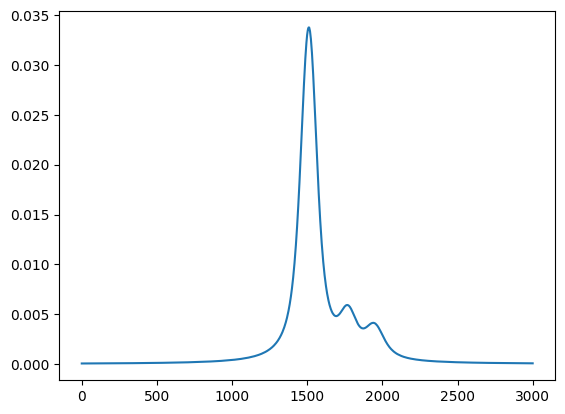

In [9]:
plt.plot(x_dat[50])

In [10]:
print(y_dat[50])

[1503.50035004]


In [11]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(X_train)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(X_train)[1],num_outputs=1,kernel=ks)

In [12]:
print(icm)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)

  ICM.             |         value  |  constraints  |  priors
  rbf.variance     |           1.0  |      +ve      |        
  rbf.lengthscale  |           1.0  |      +ve      |        
  B.W              |  [0.83431425]  |               |        
  B.kappa          |           0.5  |      +ve      |        
W matrix
   index  |     ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.83431425  |               |        

kappa vector
   index  |  ICM.B.kappa  |  constraints  |  priors
  [0]    |   0.50000000  |      +ve      |        

B matrix
 [[1.19608026]]


In [13]:
m = GPy.models.GPCoregionalizedRegression([X_train],[Y_train],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 8121423.847333502
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |         value  |  constraints  |  priors
  ICM.rbf.variance                       |           1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |           1.0  |      +ve      |        
  ICM.B.W                                |  [0.83431425]  |               |        
  ICM.B.kappa                            |           0.5  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |           1.0  |      +ve      |        


In [14]:
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)

W matrix
   index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.83431425  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        


In [15]:
m.optimize()

In [16]:
print(m)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)


Name : gp
Objective : 1716.0306183906905
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |                  value  |  constraints  |  priors
  ICM.rbf.variance                       |                    1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |     0.2009444678716138  |      +ve      |        
  ICM.B.W                                |         [357.11718725]  |               |        
  ICM.B.kappa                            |  8.363381134468531e-22  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |    0.08526921456379184  |      +ve      |        
W matrix
   index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  357.11718725  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.00000000  |      +ve      |        

B matrix
 [[127532.68543135]]


In [21]:
newX = X_test

In [24]:
newX = np.concatenate((newX,np.zeros((np.shape(X_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys,var=m.predict(newX,Y_metadata=noise_dict)

# Temper_test_=scalerT.inverse_transform(ys)


In [25]:
ys

array([[2156.4906172 ],
       [1823.55383264],
       [2078.51654978],
       ...,
       [1522.50336047],
       [1580.54019145],
       [1965.46363427]])

In [26]:
Y_test

array([[2156.94569457],
       [1823.08230823],
       [2078.46784678],
       ...,
       [1522.05220522],
       [1580.0180018 ],
       [1965.47654765]])

In [27]:
from sklearn import metrics

In [28]:
conc_1 = metrics.mean_squared_log_error(np.array(ys), np.array(Y_test))
conc_1

2.6946422538712178e-08